In [2]:
# Name: Zeyun Wu
# Date: July 8th 2019

import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import ToyQ2

In [3]:
df = pd.read_csv('UH_RL_rats.csv')
df = df.drop(df.columns[[range(24)]],axis=1)
subjects = df['subject'].unique()

/Users/erika/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:1700: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [4]:
df.head()

,session,subject,lever,response,feedback,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE
0,1,10,A,rich,0.0,1.0,1.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
1,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.139603,1.000000
2,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
3,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.259718,0.860397
4,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,0.000000


In [5]:
# divide df into 5 dfs according to session
# '1,11,16,6,Best'
session = df['session'].unique()
df_1 = df[df['session']=='1']
df_11 = df[df['session']=='11']
df_16 = df[df['session']=='16']
df_6 = df[df['session']=='6']
df_best = df[df['session']=='Best']
df_list = [df_1,df_11,df_16,df_6,df_best]

In [6]:
# action list, reward list, and Q list
action_list = []
reward_list = []
Q_list = []

# the k-th array in each list corresponds to (1+k%20)-th object in session[int(k/5)]
for i in range(len(session)):
    for j in range(len(subjects)):
        subj = j + 1 # subjects 1-20
        df_sess = df_list[i]
        action = np.array(df_sess['action'][df_sess['subject']==subj])
        reward = np.array(df_sess['reward'][df_sess['subject']==subj])
        Q = np.array(df_sess['Q'][df_sess['subject']==subj])
                
        action_list.append(action)
        reward_list.append(reward)
        Q_list.append(Q)



In [29]:
len(Q_list[10])

292

In [27]:
len(reward_list[10])

292

In [28]:
len(action_list[10])

292

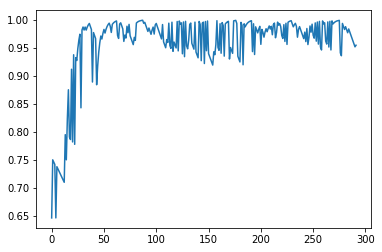

In [32]:
plt.plot(Q_list[10]) #weird
plt.show()

In [ ]:
# demo
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.2,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

Distance between Q and Q_MLE

rats with single Q and two alphas for win and lose respectively

In [41]:
# parameter: action, a list of numpy arrays of action data; reward, a list of np array of reward data
# beta, sharpness of sigmoid; alpha, learning rate; Qleft, if the Q is describing the quality for the left
# return the sum of log-likelihood
###!!! suppose the reward stands for the objective reward
def neg_log_likelihood_sigQ(alpha,beta,actions,rewards,Q=0,gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        if turn == 1:
            Q = Q + alpha*(rew - Q + gamma*np.max(Q))
        else:
            Q = Q - alpha*(rew - Q + gamma*np.max(Q))

        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*Q)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*Q)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [79]:
def neg_log_likelihood_sigQ_2alpha(alphaG,alphaL,beta,actions,rewards,Q=0,gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        
        if int(turn) == 2 & int(rew) == 1:
            rew = 0
            Q = Q + alphaG*(rew - Q + gamma*np.max(Q))
        elif int(turn) == 2 & int(rew) == 0:
            rew = 1
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))
        elif int(turn) == 1 & int(rew) == 1:
            rew = 1
            Q = Q - alphaG*(rew - Q + gamma*np.max(Q))
        else:
            rew = 0
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))
        
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*Q)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*Q)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [140]:
# params = [alphaG0,alphaL0,beta0]
# args = [actions,rewards]
def helper_func_2alpha(params,args):
    alphaG0 = params[0]
    alphaL0 = params[1]
    beta0 = params[2]
    actions = args[0]
    rewards = args[1]
    
    sum_ll = neg_log_likelihood_sigQ_2alpha(alphaG0,alphaL0,beta0,actions,rewards)
    
    return sum_ll

In [141]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0):
    initial_guess = [alphaG0,alphaL0,beta0]
    args = [actions,rewards]
    bounds = ((0,1),(0,1),(0,10*beta0))
    result = minimize(helper_func_2alpha,initial_guess,args=args,bounds = bounds)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alphaG0 equals',alphaG0)
    return result
    
    

In [10]:
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance_2alpha(iteration,alphaG0,alphaL0,beta0):
    env = ToyQ2.toyQ_2choice()
    rat = ToyQ2.SQFSrat(env, alphaF=alphaL0,alphaS=alphaG0, beta=beta0)
    env,rat = ToyQ2.train_rat(env,rat,iteration)
    
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    rewards = env.obslog
    
    result = MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0)
    alphaG_hat = result.x[0]
    alphaL_hat = result.x[1]
    beta_hat = result.x[2]
    
    rat_hat = ToyQ2.SQFSrat(env,alphaF=alphaL_hat,alphaS=alphaG_hat, beta=beta_hat)
    env,rat_hat = ToyQ2.train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    

In [18]:
#test
Q_distance_2alpha(300,0.2,0.2,2)

The optimization did not converge, beta0 equals 2 , and alphaG0 equals 0.2


0.0625702674099439

# MLE on real data

Suppose actions and rewards are exactly same as the real experiment, use the alphas and beta in the dataset and calculate the mean squared error between Q in dataset and MLE Q

Also suppose the action function is sigmoid

In [20]:
# load data
df = pd.read_csv('UH_RL_rats.csv')
df = df.drop(df.columns[[range(24)]],axis=1)
subjects = df['subject'].unique()

/Users/erika/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:1700: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [21]:
# divide df into 5 dfs according to session
# '1,11,16,6,Best'
session = df['session'].unique()
df_1 = df[df['session']=='1']
df_11 = df[df['session']=='11']
df_16 = df[df['session']=='16']
df_6 = df[df['session']=='6']
df_best = df[df['session']=='Best']
df_list = [df_1,df_11,df_16,df_6,df_best]

In [56]:
# action list, reward list, and Q list
action_list = []
reward_list = []
Q_list = []
alphaG_list = []
alphaL_list = []
beta_list = []

# the k-th array in each list corresponds to (1+k%20)-th object in session[int(k/5)]
for i in range(len(session)):
    for j in range(len(subjects)):
        subj = j + 1 # subjects 1-20
        df_sess = df_list[i]
        action = np.array(df_sess['action'][df_sess['subject']==subj])
        reward = np.array(df_sess['reward'][df_sess['subject']==subj])
        Q = np.array(df_sess['Q'][df_sess['subject']==subj])
        alphaG = np.unique(df_sess['alpha_gain'][df_sess['subject']==subj])
        alphaL = np.unique(df_sess['alpha_loss'][df_sess['subject']==subj])
        beta = np.unique(df_sess['beta'][df_sess['subject']==subj])
                
        action_list.append(action)
        reward_list.append(reward)
        Q_list.append(Q)
        alphaG_list.append(alphaG)
        alphaL_list.append(alphaL)
        beta_list.append(beta)


In [55]:
df.head()

,session,subject,lever,response,feedback,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE
0,1,10,A,rich,0.0,1.0,1.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
1,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.139603,1.000000
2,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
3,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.259718,0.860397
4,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,0.000000


In [94]:
#calculate mean square error between Qlog and Q_hat
#return both mle result and mse
def simple_Q_distance(alphaG0,alphaL0,beta0,actions,rewards,Qlog):
    iteration = len(Qlog)
    
    MLE_result = MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0)
    alphaG_hat = MLE_result.x[0]
    alphaL_hat = MLE_result.x[1]
    beta_hat = MLE_result.x[2]
    
    #get Q_hat from simulation
    env = ToyQ2.toyQ_2choice()
    rat_hat = ToyQ2.SQFSrat(env,alphaF=alphaL_hat,alphaS=alphaG_hat, beta=beta_hat)
    env,rat_hat = ToyQ2.train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    Q_hat = Q_hat[:-1] # the last Q was not used in deciding the rat's action
    
    
    mse = np.linalg.norm(Qlog-Q_hat)**2/iteration 
    return MLE_result,mse
    
    

In [80]:
#demo
mle,mse = simple_Q_distance(0.139603,1.0,20.0,action_list[0],reward_list[0],Q_list[0])

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


In [81]:
mle

      fun: 5.444891942680578
 hess_inv: array([[4379.13193247, -623.48758303, 2935.33681887],
       [-623.48758303,   89.05639837, -418.25534566],
       [2935.33681887, -418.25534566, 1968.95802283]])
      jac: array([-2.02655792e-06,  5.06639481e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 110
      nit: 20
     njev: 22
   status: 0
  success: True
        x: array([8.89337750e-01, 3.17758577e-03, 2.02592918e+01])

In [85]:
# check if all alphas and beta are MLE result
truth_list = []
mse_list = []
for i in range(len(alphaG_list)):
    mle,mse = simple_Q_distance(alphaG_list[i][0],alphaL_list[i][0],beta_list[i][0],action_list[i],reward_list[i],
                                Q_list[i])
    val = abs(mle.x[0] - alphaG_list[i][0])/mle.x[0] < 0.1
    val = val and abs(mle.x[1] - alphaL_list[i][0])/mle.x[1] < 0.1
    val = val and abs(mle.x[2] - beta_list[i][0])/mle.x[2] <0.2
    
    truth_list.append(val)
    mse_list.append(mse)

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/pytho

The optimization did not converge, beta0 equals 0.0116936679912 , and alphaG0 equals 0.0006500555444439999


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/erika/a

The optimization did not converge, beta0 equals 0.000711877618334 , and alphaG0 equals 3.00272320299e-05


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))


The optimization did not converge, beta0 equals 0.726263703524 , and alphaG0 equals 0.18582544577799998


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


The optimization did not converge, beta0 equals 0.536254523587 , and alphaG0 equals 0.545370052041


/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


The optimization did not converge, beta0 equals 0.5888181635549999 , and alphaG0 equals 0.14170465664100002


/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


The optimization did not converge, beta0 equals 0.347512382615 , and alphaG0 equals 0.11709156960999999


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/Users/erika/anaconda

The optimization did not converge, beta0 equals 0.154716349968 , and alphaG0 equals 0.261299314818


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/erika/Lab/m/MLE_simulated/ToyQ2.py:23: RuntimeWarning: overflow encountered in exp
  val = 1/(1+np.exp(0-beta*q))
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


The optimization did not converge, beta0 equals 0.378301326316 , and alphaG0 equals 0.681418991388


In [96]:
df.head()

,session,subject,lever,response,feedback,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE
0,1,10,A,rich,0.0,1.0,1.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
1,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.139603,1.000000
2,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
3,1,10,A,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.259718,0.860397
4,1,10,B,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,0.000000


## Simulated rats with 2 alphas

In [117]:
# temp
def neg_log_likelihood_sigQ_2alpha(alphaG,alphaL,beta,actions,rewards,Q=0,gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        
        if (turn == np.array([0,1])).all() & (rew == np.array([0,1])).all():
            rew = 0
            Q = Q + alphaG*(rew - Q + gamma*np.max(Q))
        elif (turn == np.array([0,1])).all() & (rew == np.array([1,0])).all():
            rew = 1
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))
        elif (turn == np.array([1,0])).all() & (rew == np.array([1,0])).all():
            rew = 1
            Q = Q - alphaG*(rew - Q + gamma*np.max(Q))
        else:
            rew = 0
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))

        
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*Q)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*Q)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [133]:
env = ToyQ2.toyQ_2choice()
rat = ToyQ2.SQFSrat(env,alphaF=0.3,alphaS=0.2, beta=4)
env,rat = ToyQ2.train_rat(env,rat,100)
Q = np.array(rat_hat.Qlog)

In [134]:
actions = rat.choiceLog
rewards = env.obslog

In [135]:
MLE_2alpha(actions,rewards,0.2,0.4,4)

      fun: 69.24764802738692
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.89004652, 0.        , 0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([0.        , 1.        , 0.34387535])

In [143]:
neg_log_likelihood_sigQ_2alpha(0.2,0.4,4,actions,rewards,Q=0,gamma=0,Qleft=True)

81.2977602818634

In [142]:
helper_func_2alpha(params=(0,2,0,4,4),args=(actions,rewards))

69.24764802738692